#### Comparison between virus infected and control wells

In [56]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import re
from tqdm.auto import tqdm

from PyPlaque.experiment import ExperimentFluorescencePlaque
from PyPlaque.utils import create_grouped_bar_from_df
from PyPlaque.view import WellImageReadout, PlateReadout

np.random.seed(0)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Initialising parameters and data

In [5]:
#loading multiple plates and plate masks as an experiment
base_dir = '../../../../data_backup/samples_fluorescent_plaques/'
exp = ExperimentFluorescencePlaque(base_dir+'images',base_dir+'masks',params = None) # default values in class, option to update

#In this case, the individual plates are of 384 well plates for fluorescence plaques and
#their corresponding mask directories. Make sure to have similar directories for images and masks(even if empty)
plate_dirs, plate_mask_dirs = exp.get_individual_plates(folder_pattern=r'^200601')

print(plate_dirs, plate_mask_dirs)

#We are choosing via the pattern above to ignore all other plates other than this one
print(exp.get_number_of_plates())


['200601-zplate-g2'] ['200601-zplate-g2']
1


In [8]:
#Example considering all wells for channel w2 from the selected plate
#Masks are generated based on the params given or the default at load time, masks can be saved in the mask directory for future use
plate_dict_w2 = exp.load_wells_for_plate_virus(plate_id=0,additional_subfolders='2020-06-03/2072',file_pattern=r'_w2') #'_([A-C]{1})1([1-4]{1})_s1_w2')
print(plate_dict_w2.keys())

768it [00:00, 281010.68it/s]
  0%|          | 0/384 [00:00<?, ?it/s]

100%|██████████| 384/384 [02:22<00:00,  2.70it/s]

dict_keys(['200601-zplate-g2'])


In [9]:
print(len(plate_dict_w2['200601-zplate-g2']['img']))

384


../../../../data_backup/samples_fluorescent_plaques/images/200601-zplate-g2/2020-06-03/2072/200601-zplate-g2_A09_s1_w2.tif


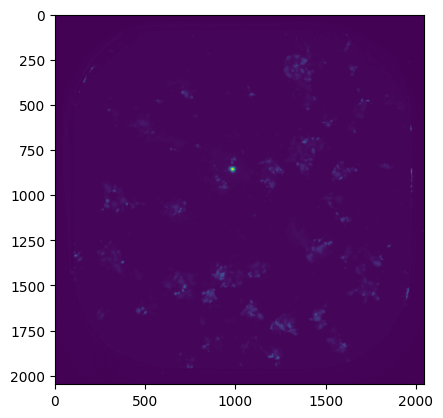

In [10]:
print(plate_dict_w2['200601-zplate-g2']['image_name'][8])
plt.imshow(plate_dict_w2['200601-zplate-g2']['img'][8])


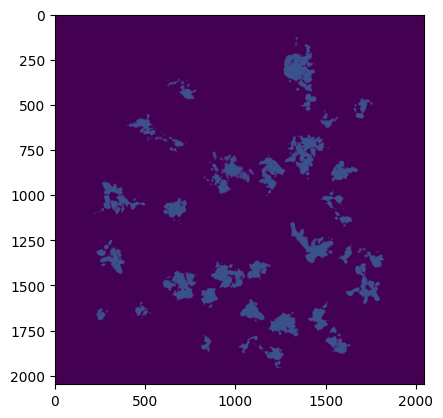

In [11]:
plt.imshow(plate_dict_w2['200601-zplate-g2']['mask'][8],vmin=0,vmax=4)

In [16]:
#Example considering a few wells for channel w1 from the selected plate
plate_dict_w1 = exp.load_wells_for_plate_nuclei(plate_id=0,additional_subfolders='2020-06-03/2072',
                                                        file_pattern=r'_w1') #'_([A-C]{1})1([1-4]{1})_s1_w1')
print(plate_dict_w1.keys())

768it [00:00, 266856.55it/s]
  0%|          | 0/384 [00:00<?, ?it/s]

  0%|          | 0/384 [00:00<?, ?it/s]

100%|██████████| 384/384 [53:44<00:00,  8.40s/it]
384it [53:44,  8.40s/it]
384it [53:44,  8.40s/it]


dict_keys(['200601-zplate-g2'])


In [17]:
print(len(plate_dict_w1['200601-zplate-g2']['img']))

384


../../../../data_backup/samples_fluorescent_plaques/images/200601-zplate-g2/2020-06-03/2072/200601-zplate-g2_A01_s1_w1.tif


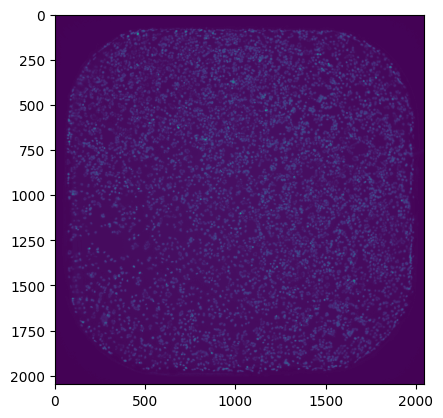

In [18]:
print(plate_dict_w1['200601-zplate-g2']['image_name'][0])
plt.imshow(plate_dict_w1['200601-zplate-g2']['img'][0])

In [25]:
plate_readout = PlateReadout(experiment = exp, plate_id = 0, well_level_readouts=True, object_level_readouts=True )
abs_df_image, abs_df_object = plate_readout.generate_readouts_dataframe() # make sure to add row and column patterns here

  0%|          | 0/384 [00:00<?, ?it/s]

100%|██████████| 384/384 [15:18<00:00,  2.39s/it]


In [26]:
abs_df_image

,NucleiImageName,VirusImageName,maxNucleiIntensity,totalNucleiIntensity,meanNucleiIntensity,numberOfNuclei,maxVirusIntensity,totalVirusIntensity,meanVirusIntensity,numberOfPlaques,numberOfInfectedNuclei
0,200601-zplate-g2_A01_s1_w1.tif,200601-zplate-g2_A01_s1_w2.tif,32308,9.286470e+09,1023.500000,18275,37322,7327763701,1747.075010,32,2165
1,200601-zplate-g2_A02_s1_w1.tif,200601-zplate-g2_A02_s1_w2.tif,32760,9.153714e+09,1023.502115,18372,45051,7505195868,1789.378135,30,2538
2,200601-zplate-g2_A03_s1_w1.tif,200601-zplate-g2_A03_s1_w2.tif,32689,9.248216e+09,1023.500556,18185,31160,7630521258,1819.258036,41,3619
3,200601-zplate-g2_A04_s1_w1.tif,200601-zplate-g2_A04_s1_w2.tif,32732,9.107313e+09,1023.500000,18269,53822,7526026914,1794.344643,30,3256
4,200601-zplate-g2_A05_s1_w1.tif,200601-zplate-g2_A05_s1_w2.tif,32760,9.052582e+09,1023.733628,17722,51669,7437289993,1773.188112,28,2726
...,...,...,...,...,...,...,...,...,...,...,...
379,200601-zplate-g2_P20_s1_w1.tif,200601-zplate-g2_P20_s1_w2.tif,31874,8.420142e+09,1023.499938,16564,23784,6707526805,1599.199010,0,0
380,200601-zplate-g2_P21_s1_w1.tif,200601-zplate-g2_P21_s1_w2.tif,32692,8.274983e+09,1023.500255,16279,17203,6759969589,1611.702344,0,0
381,200601-zplate-g2_P22_s1_w1.tif,200601-zplate-g2_P22_s1_w2.tif,32127,8.381441e+09,1023.499818,16444,16584,6768408080,1613.714237,0,0
382,200601-zplate-g2_P23_s1_w1.tif,200601-zplate-g2_P23_s1_w2.tif,29627,7.926082e+09,1023.500000,15224,56963,6721685174,1602.574628,0,0


In [27]:
control_regex = '_([A-C]{1})(1[3-9]{1}|2[0-4]{1})_s1_w1' #'_([A-C]{1})1([3-4]{1})_s1_w1'
abs_df_image_control = abs_df_image[abs_df_image.NucleiImageName.str.contains(control_regex)]

/var/folders/ww/drh8wc992nxcqb4z8dmykc440000gn/T/ipykernel_58270/300884381.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  abs_df_image_control = abs_df_image[abs_df_image.NucleiImageName.str.contains(control_regex)]


In [28]:
abs_df_image_control

,NucleiImageName,VirusImageName,maxNucleiIntensity,totalNucleiIntensity,meanNucleiIntensity,numberOfNuclei,maxVirusIntensity,totalVirusIntensity,meanVirusIntensity,numberOfPlaques,numberOfInfectedNuclei
12,200601-zplate-g2_A13_s1_w1.tif,200601-zplate-g2_A13_s1_w2.tif,32691,9.022117e+09,1023.500441,18059,11473,6748545039,1608.978519,1,69
13,200601-zplate-g2_A14_s1_w1.tif,200601-zplate-g2_A14_s1_w2.tif,32727,8.890458e+09,1023.500000,17995,65535,6760565544,1611.844431,0,0
14,200601-zplate-g2_A15_s1_w1.tif,200601-zplate-g2_A15_s1_w2.tif,32456,8.852070e+09,1023.499927,17535,12064,6747640885,1608.762952,0,0
15,200601-zplate-g2_A16_s1_w1.tif,200601-zplate-g2_A16_s1_w2.tif,32357,8.617320e+09,1023.499953,16415,6698,6697975296,1596.921753,1,33
16,200601-zplate-g2_A17_s1_w1.tif,200601-zplate-g2_A17_s1_w2.tif,32605,8.634530e+09,1023.499669,16662,6751,6676771941,1591.866479,0,0
17,200601-zplate-g2_A18_s1_w1.tif,200601-zplate-g2_A18_s1_w2.tif,32596,8.606332e+09,1023.504936,16664,7819,6695794414,1596.401790,0,0
18,200601-zplate-g2_A19_s1_w1.tif,200601-zplate-g2_A19_s1_w2.tif,32344,8.995931e+09,1023.506147,16736,17558,6885570785,1641.648003,0,0
19,200601-zplate-g2_A20_s1_w1.tif,200601-zplate-g2_A20_s1_w2.tif,32178,9.180417e+09,1023.500556,17621,11524,6888077045,1642.245542,0,0
20,200601-zplate-g2_A21_s1_w1.tif,200601-zplate-g2_A21_s1_w2.tif,30905,8.886977e+09,1023.499669,16706,8878,6882060700,1640.811133,0,0
21,200601-zplate-g2_A22_s1_w1.tif,200601-zplate-g2_A22_s1_w2.tif,31809,8.810940e+09,1023.500032,16839,12149,6886343952,1641.832340,0,0


In [29]:
viral_regex = '_([A-C]{1})(0[1-9]{1}|1[0-2]{1})_s1_w1' #'_([A-C]{1})1([1-2]{1})_s1_w1'
abs_df_image_viral = abs_df_image[abs_df_image.NucleiImageName.str.contains(viral_regex)]

/var/folders/ww/drh8wc992nxcqb4z8dmykc440000gn/T/ipykernel_58270/892574542.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  abs_df_image_viral = abs_df_image[abs_df_image.NucleiImageName.str.contains(viral_regex)]


In [30]:
abs_df_image_viral

,NucleiImageName,VirusImageName,maxNucleiIntensity,totalNucleiIntensity,meanNucleiIntensity,numberOfNuclei,maxVirusIntensity,totalVirusIntensity,meanVirusIntensity,numberOfPlaques,numberOfInfectedNuclei
0,200601-zplate-g2_A01_s1_w1.tif,200601-zplate-g2_A01_s1_w2.tif,32308,9.286470e+09,1023.500000,18275,37322,7327763701,1747.075010,32,2165
1,200601-zplate-g2_A02_s1_w1.tif,200601-zplate-g2_A02_s1_w2.tif,32760,9.153714e+09,1023.502115,18372,45051,7505195868,1789.378135,30,2538
2,200601-zplate-g2_A03_s1_w1.tif,200601-zplate-g2_A03_s1_w2.tif,32689,9.248216e+09,1023.500556,18185,31160,7630521258,1819.258036,41,3619
3,200601-zplate-g2_A04_s1_w1.tif,200601-zplate-g2_A04_s1_w2.tif,32732,9.107313e+09,1023.500000,18269,53822,7526026914,1794.344643,30,3256
4,200601-zplate-g2_A05_s1_w1.tif,200601-zplate-g2_A05_s1_w2.tif,32760,9.052582e+09,1023.733628,17722,51669,7437289993,1773.188112,28,2726
5,200601-zplate-g2_A06_s1_w1.tif,200601-zplate-g2_A06_s1_w2.tif,32760,8.984982e+09,1023.500139,17801,34068,7603828039,1812.893877,37,3720
6,200601-zplate-g2_A07_s1_w1.tif,200601-zplate-g2_A07_s1_w2.tif,32686,8.810041e+09,1023.500000,17002,35851,7308746106,1742.540862,30,2024
7,200601-zplate-g2_A08_s1_w1.tif,200601-zplate-g2_A08_s1_w2.tif,32069,8.863885e+09,1023.501334,17478,35663,7301749902,1740.872837,34,2513
8,200601-zplate-g2_A09_s1_w1.tif,200601-zplate-g2_A09_s1_w2.tif,31368,9.089009e+09,1023.500000,17809,46247,7338099389,1749.539230,28,2815
9,200601-zplate-g2_A10_s1_w1.tif,200601-zplate-g2_A10_s1_w2.tif,32284,8.804154e+09,1023.499401,17140,65535,7368535931,1756.795867,30,2612


In [31]:
abs_df_object

,wellRow,wellColumn,Area,Centroid_1,Centroid_2,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Roundness,numberOfPeaks,numberOfNucleiInPlaque,numberOfInfectedNucleiInPlaque,maxIntensityGFP,totalIntensityGFP,meanIntensityGFP
0,A,01,5751.968750,779.354547,1152.336421,132.380125,73.014855,0.787246,8976.062500,0.267066,1.0,58.320956,46.412132,11871.812500,2.043244e+07,55.359951
1,A,02,7191.766667,1015.005792,981.926309,130.682315,78.943512,0.745286,11420.733333,0.279096,1.0,70.430196,51.333333,13636.000000,2.882249e+07,59.285028
2,A,03,6151.740000,1007.292569,1007.246519,129.229685,78.555681,0.740695,9770.620000,0.272435,1.0,58.503765,46.063765,12213.860000,2.171966e+07,56.647467
3,A,04,8649.562500,1097.021821,988.087295,161.363700,86.831082,0.788209,13666.125000,0.267983,1.0,79.509926,61.627206,15030.250000,3.259878e+07,67.890325
4,A,05,6435.305556,949.258704,1075.016362,131.523756,78.214232,0.743000,9890.777778,0.270576,1.0,60.426797,46.902941,10471.888889,2.349374e+07,57.254136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,P,20,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000
380,P,21,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000
381,P,22,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000
382,P,23,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000


In [32]:
control_regex = '(1[3-9]{1}|2[0-4]{1})' #'1[3-4]{1}'
abs_df_object_control = abs_df_object[abs_df_object.wellColumn.str.contains(control_regex)]


/var/folders/ww/drh8wc992nxcqb4z8dmykc440000gn/T/ipykernel_58270/2213887764.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  abs_df_object_control = abs_df_object[abs_df_object.wellColumn.str.contains(control_regex)]


In [33]:
abs_df_object_control 

,wellRow,wellColumn,Area,Centroid_1,Centroid_2,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Roundness,numberOfPeaks,numberOfNucleiInPlaque,numberOfInfectedNucleiInPlaque,maxIntensityGFP,totalIntensityGFP,meanIntensityGFP
12,A,13,5844.0,313.346338,1789.969199,534.812721,32.850653,0.998112,17716.0,0.031211,2.0,162.670588,69.235294,6510.0,18066387.0,142.441801
13,A,14,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
14,A,15,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
15,A,16,2835.0,255.850794,712.449030,116.864557,47.285217,0.914487,5146.0,0.191818,1.0,59.788235,33.658824,3621.0,7026861.0,46.210867
16,A,17,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,P,20,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
380,P,21,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
381,P,22,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
382,P,23,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000


In [34]:
viral_regex = '(0[1-9]{1}|1[0-2]{1})' #'1[1-2]{1}'
abs_df_object_viral = abs_df_object[abs_df_object.wellColumn.str.contains(viral_regex)]


/var/folders/ww/drh8wc992nxcqb4z8dmykc440000gn/T/ipykernel_58270/859026500.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  abs_df_object_viral = abs_df_object[abs_df_object.wellColumn.str.contains(viral_regex)]


In [35]:
abs_df_object_viral

,wellRow,wellColumn,Area,Centroid_1,Centroid_2,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Roundness,numberOfPeaks,numberOfNucleiInPlaque,numberOfInfectedNucleiInPlaque,maxIntensityGFP,totalIntensityGFP,meanIntensityGFP
0,A,01,5751.968750,779.354547,1152.336421,132.380125,73.014855,0.787246,8976.062500,0.267066,1.0,58.320956,46.412132,11871.812500,2.043244e+07,55.359951
1,A,02,7191.766667,1015.005792,981.926309,130.682315,78.943512,0.745286,11420.733333,0.279096,1.0,70.430196,51.333333,13636.000000,2.882249e+07,59.285028
2,A,03,6151.740000,1007.292569,1007.246519,129.229685,78.555681,0.740695,9770.620000,0.272435,1.0,58.503765,46.063765,12213.860000,2.171966e+07,56.647467
3,A,04,8649.562500,1097.021821,988.087295,161.363700,86.831082,0.788209,13666.125000,0.267983,1.0,79.509926,61.627206,15030.250000,3.259878e+07,67.890325
4,A,05,6435.305556,949.258704,1075.016362,131.523756,78.214232,0.743000,9890.777778,0.270576,1.0,60.426797,46.902941,10471.888889,2.349374e+07,57.254136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367,P,08,5270.088235,856.262617,1164.292492,120.245881,68.759817,0.781661,7776.794118,0.299824,1.0,48.064360,39.543945,10750.235294,1.950769e+07,50.581261
368,P,09,4479.862069,883.589570,1054.220887,118.374508,63.804978,0.810632,6699.206897,0.271014,1.0,38.271400,31.230832,10526.620690,1.640222e+07,47.914743
369,P,10,6650.689655,1051.603547,1078.389524,136.095050,73.480269,0.802405,10132.448276,0.279356,1.0,57.731440,46.735903,10595.241379,2.470992e+07,57.261560
370,P,11,6220.939394,960.105209,1061.702339,129.332489,75.791988,0.746356,9367.818182,0.276833,1.0,52.556863,44.508734,9404.000000,2.255234e+07,55.783151


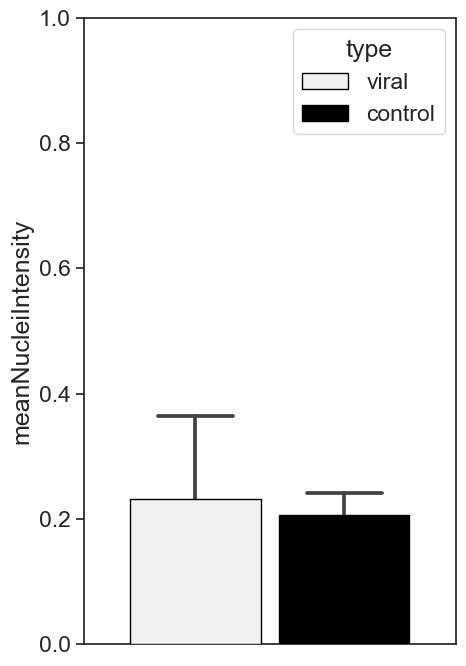

In [38]:
create_grouped_bar_from_df(abs_df_image_viral,abs_df_image_control,'meanNucleiIntensity', normalize=True) #save_path='../../../../manuscript/figs/comparison_meanNucleiIntensity.svg')

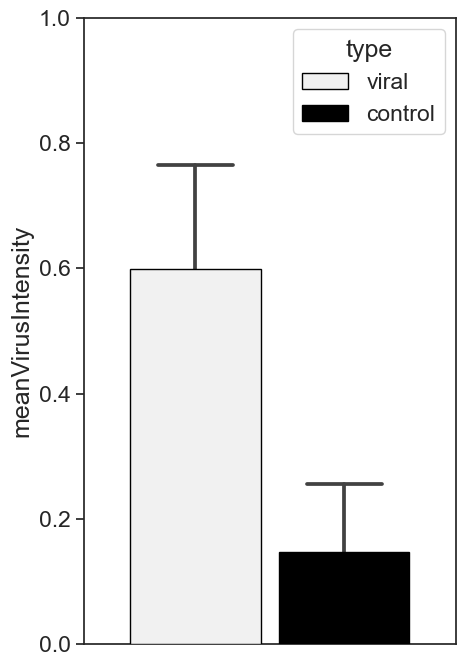

In [39]:
create_grouped_bar_from_df(abs_df_image_viral,abs_df_image_control,'meanVirusIntensity', normalize=True) #save_path='../../../../manuscript/figs/comparison_meanVirusIntensity.svg')

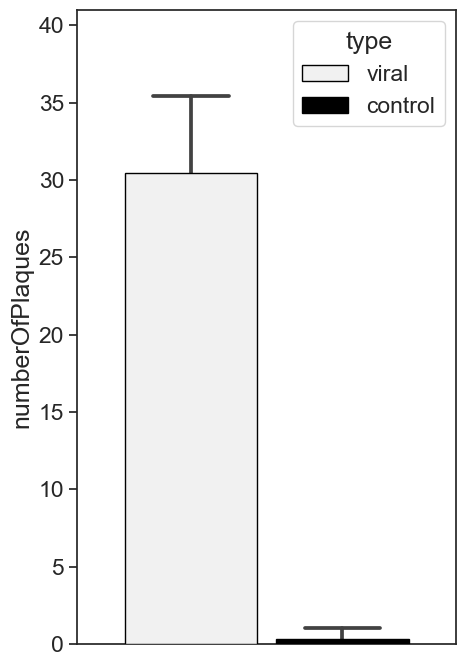

In [40]:
create_grouped_bar_from_df(abs_df_image_viral,abs_df_image_control,'numberOfPlaques') #save_path='../../../../manuscript/figs/comparison_numberOfPlaques.svg')

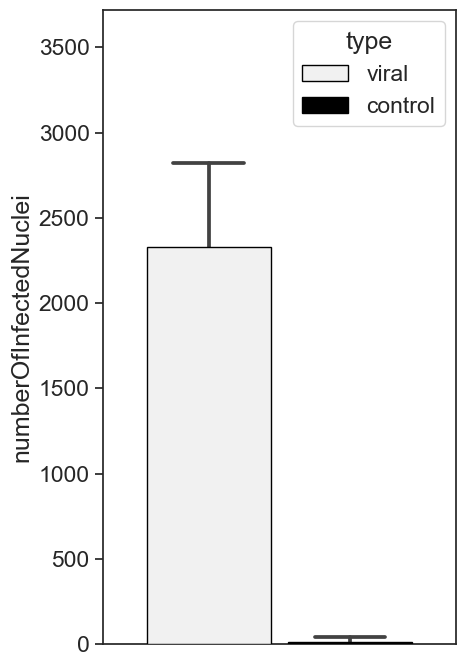

In [41]:
create_grouped_bar_from_df(abs_df_image_viral,abs_df_image_control,'numberOfInfectedNuclei') #save_path='../../../../manuscript/figs/comparison_numberOfInfectedNuclei.svg')

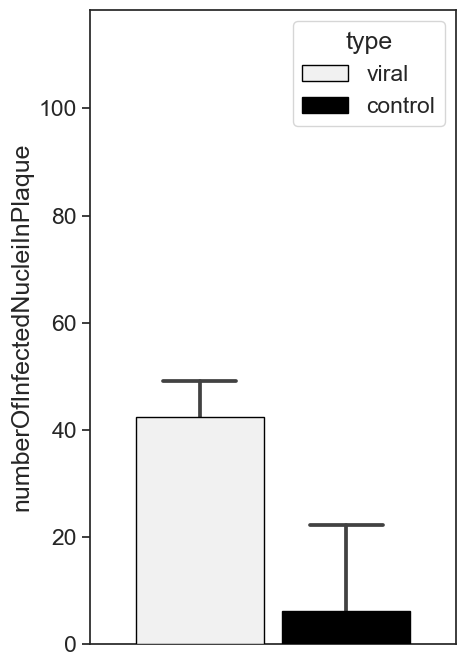

In [49]:
create_grouped_bar_from_df(abs_df_object_viral,abs_df_object_control,'numberOfInfectedNucleiInPlaque') #save_path='../../../../manuscript/figs/comparison_numberOfInfectedNucleiInPlaque.svg')

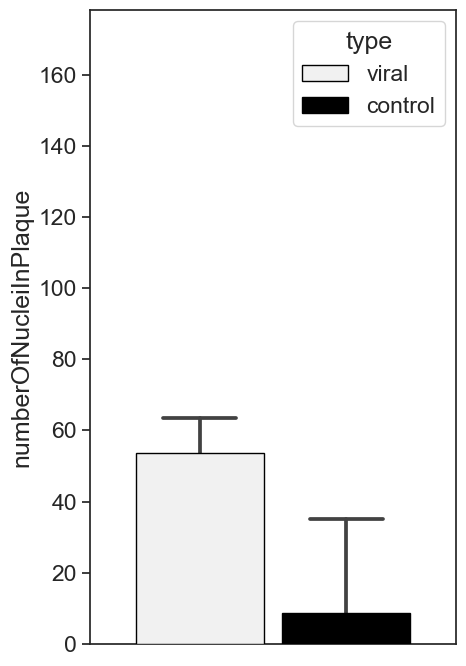

In [50]:
create_grouped_bar_from_df(abs_df_object_viral,abs_df_object_control,'numberOfNucleiInPlaque') #save_path='../../../../manuscript/figs/comparison_numberOfNucleiInPlaque.svg')

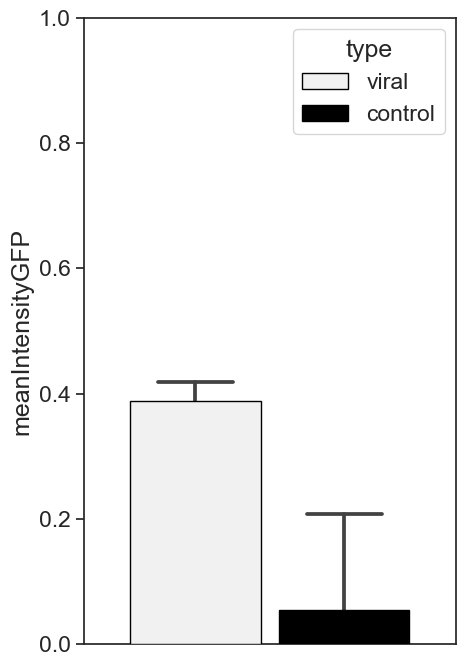

In [52]:
create_grouped_bar_from_df(abs_df_object_viral,abs_df_object_control,'meanIntensityGFP', normalize=True) #save_path='../../../../manuscript/figs/comparison_meanIntensityGFP.svg')

#### Probe into objects that have been found in the control section of the plate

  0%|          | 0/384 [00:00<?, ?it/s]

 55%|█████▌    | 212/384 [03:09<02:36,  1.10it/s]/var/folders/ww/drh8wc992nxcqb4z8dmykc440000gn/T/ipykernel_58270/1788745379.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()
100%|██████████| 384/384 [05:44<00:00,  1.12it/s]


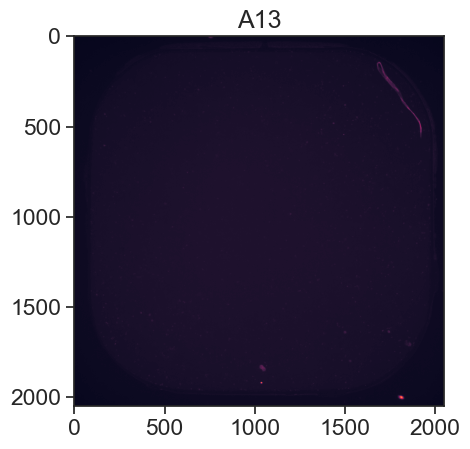

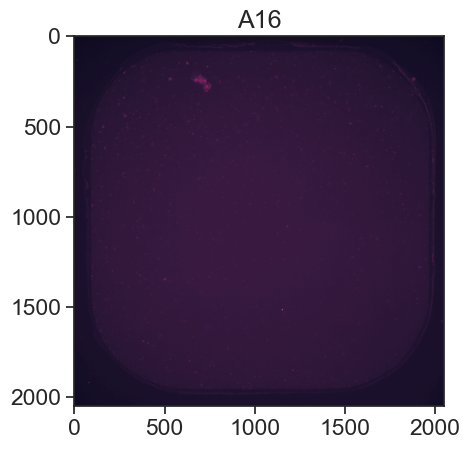

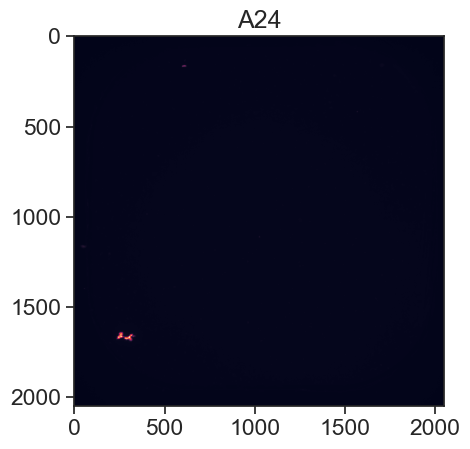

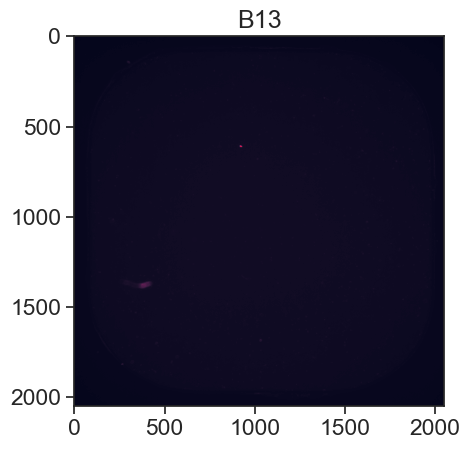

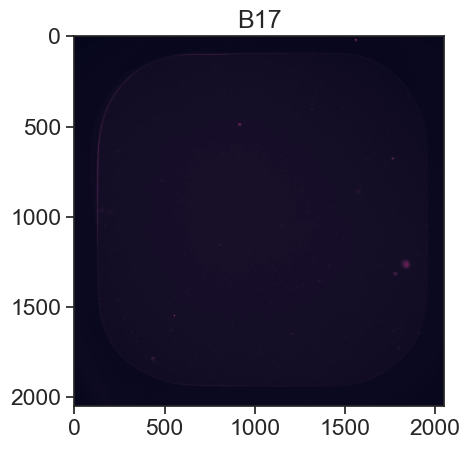

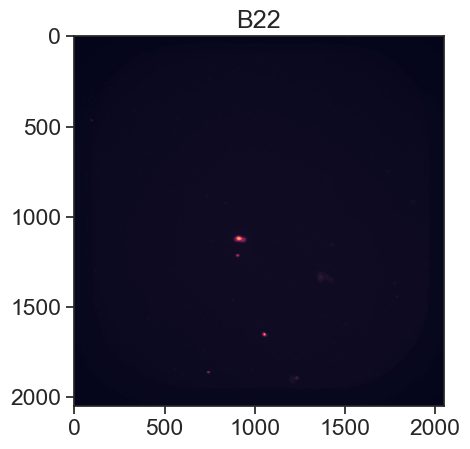

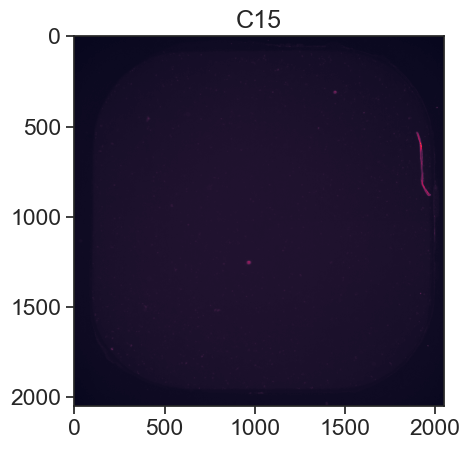

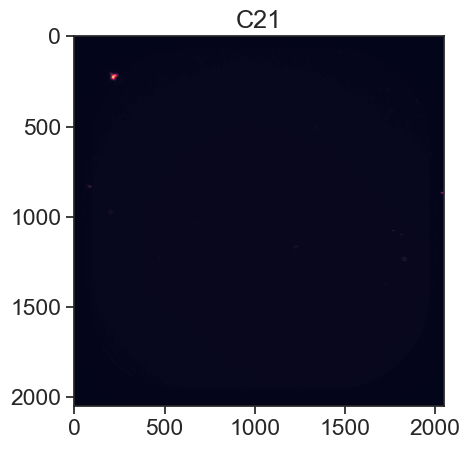

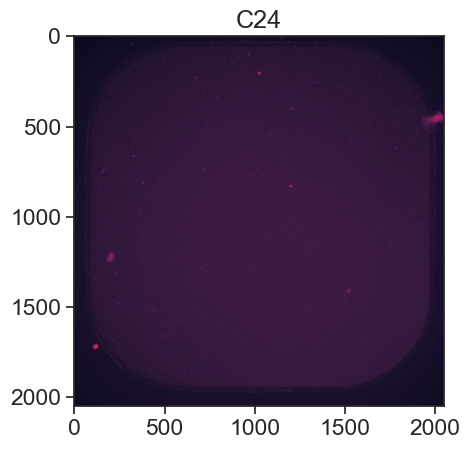

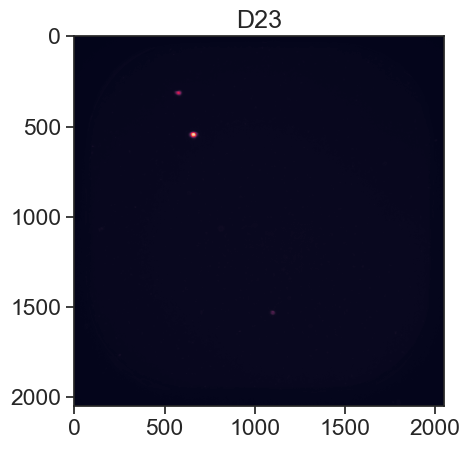

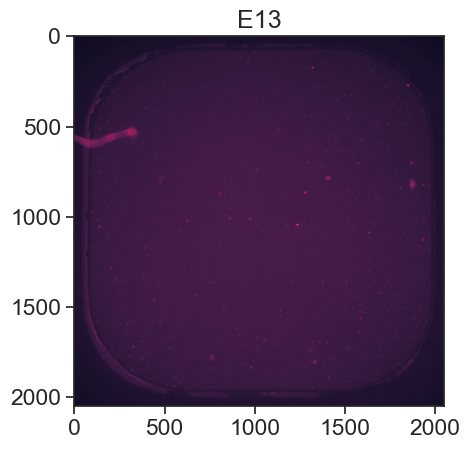

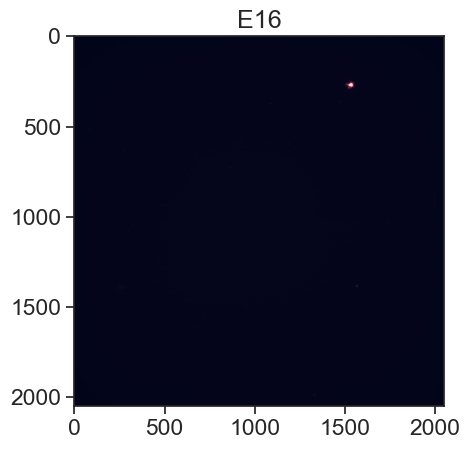

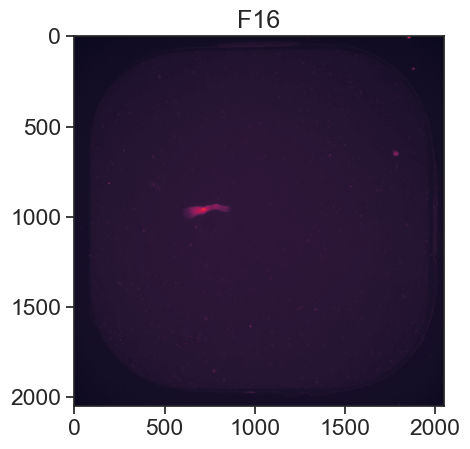

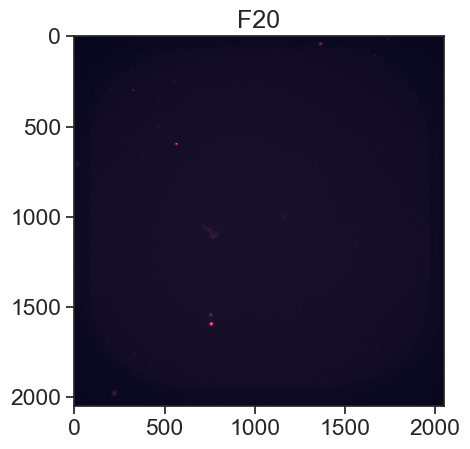

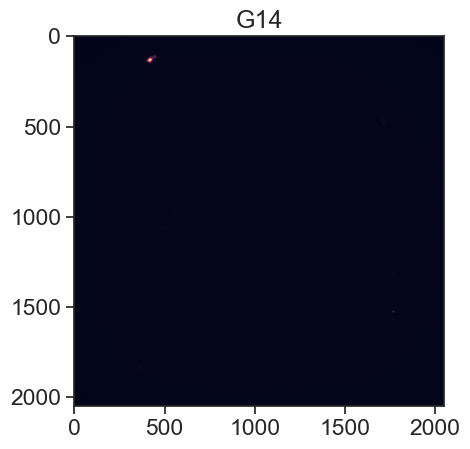

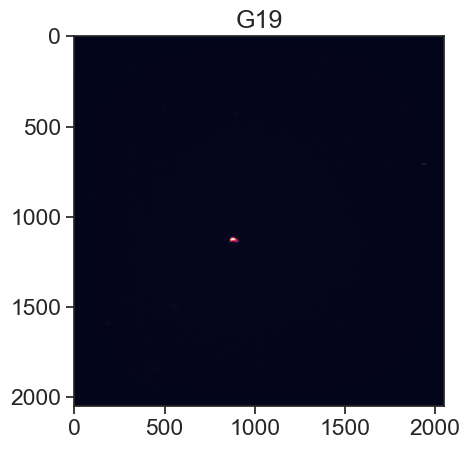

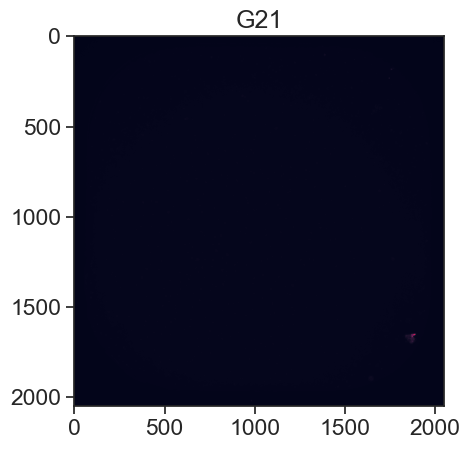

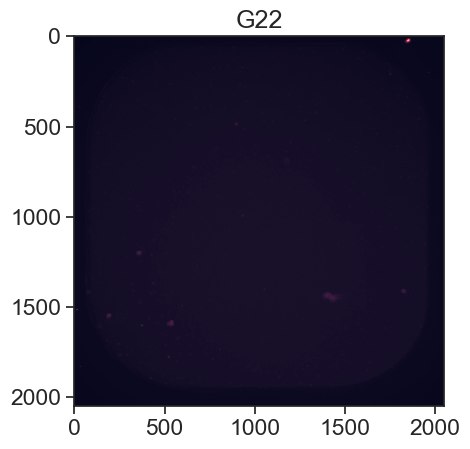

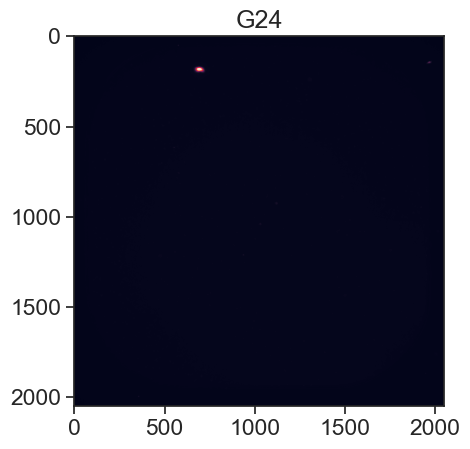

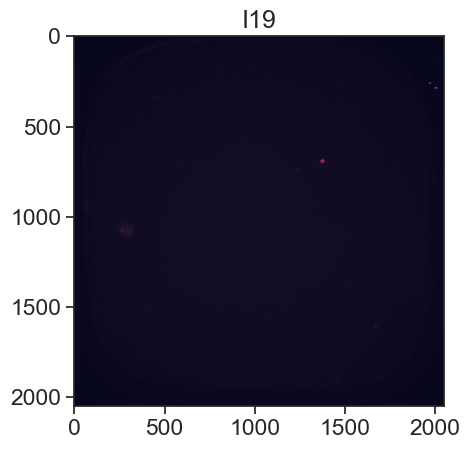

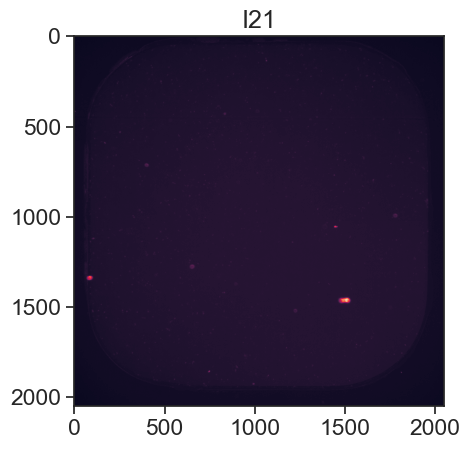

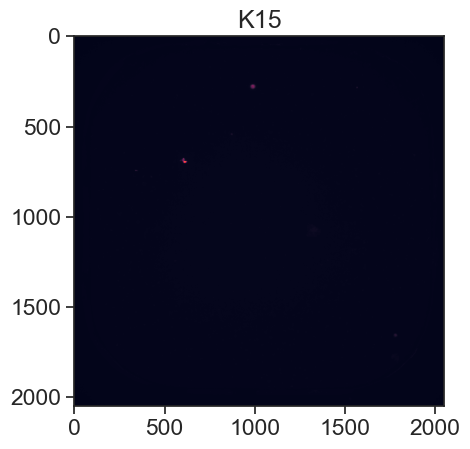

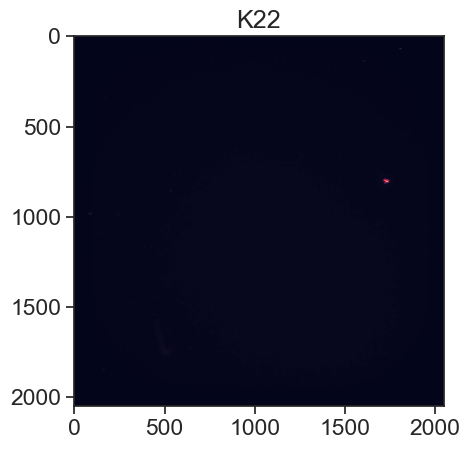

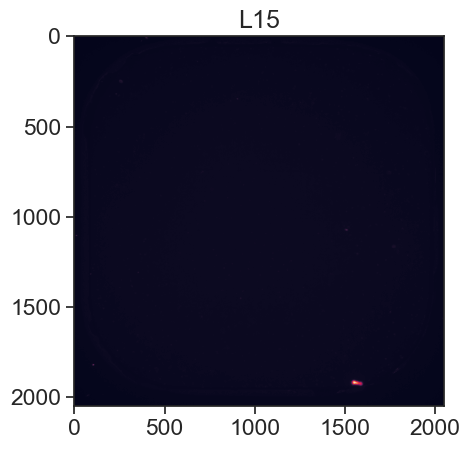

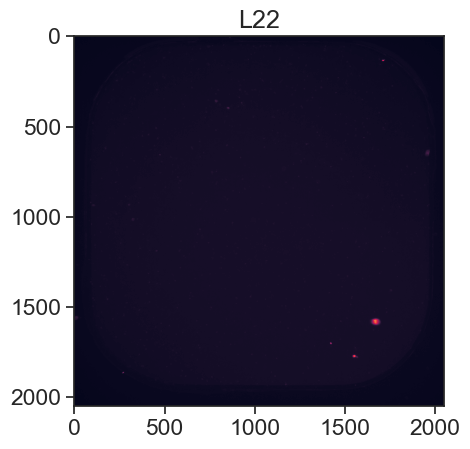

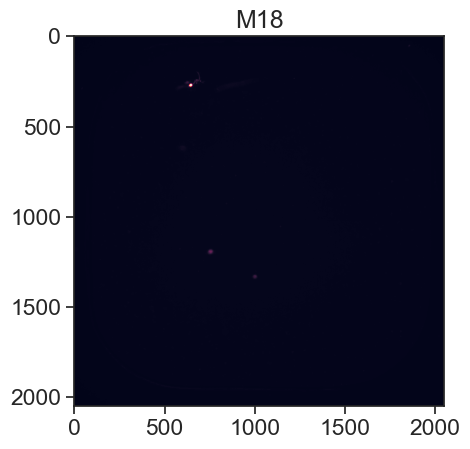

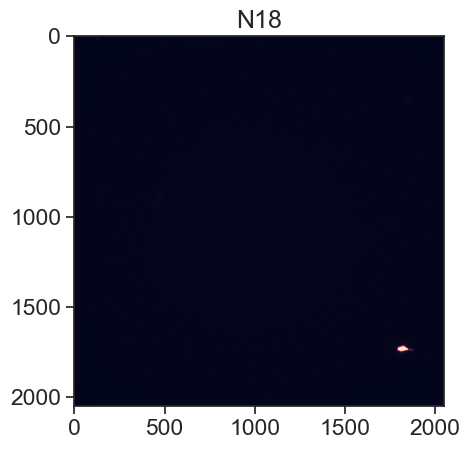

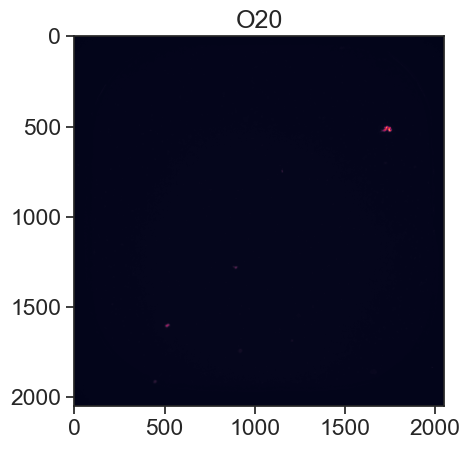

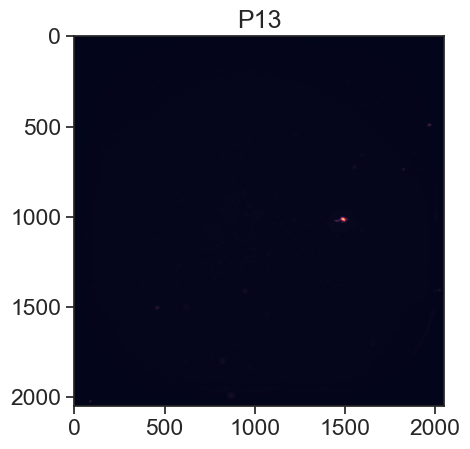

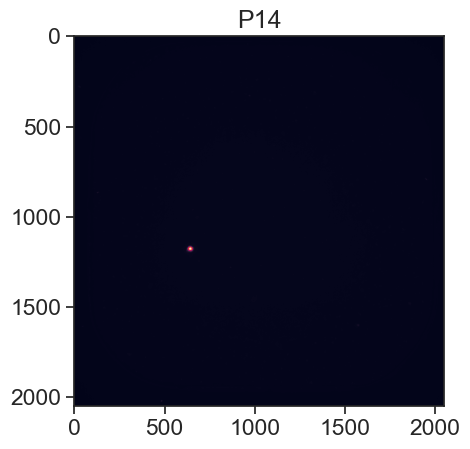

In [58]:
d = exp.plate_indiv_dir[0]

for i in tqdm(range(len(exp.plate_dict_w2[d]['img']))):
    plq_image_readout = WellImageReadout(nuclei_image_name=str(exp.plate_dict_w1[d]
                                        ['image_name'][i]).split("/")[-1],
                            plaque_image_name=str(exp.plate_dict_w2[d]['image_name'][i]).split("/")[-1],
                            nuclei_image=np.array(exp.plate_dict_w1[d]['img'][i]),
                            plaque_image=np.array(exp.plate_dict_w2[d]['img'][i]),
                            nuclei_mask=np.array(exp.plate_dict_w1[d]['mask'][i]),
                            plaque_mask=np.array(exp.plate_dict_w2[d]['mask'][i]),
                            virus_params=exp.params['virus'])
                            
    well_id = plq_image_readout.get_row(row_pattern = r'([A-Z]{1}[0-9]{2})')
    col_id = plq_image_readout.get_column(column_pattern = r'[A-Z]{1}([0-9]{2})')

    plq_objects = plq_image_readout.get_plaque_objects()
            
    if len(re.findall(r'(1[3-9]{1}|2[0-4]{1})', col_id))>0:
        if len(plq_objects) != 0:
            plt.figure()
            plt.imshow(plate_dict_w2['200601-zplate-g2']['img'][i])
            plt.title(well_id)
